# Filtering the Congressional Record and Hansard


This notebook contains the code needed to filter the Congressional Record and Hansard datasets. The code creates two pairs of corpuses with cleaned and stemmed text. The first pair contains only speeches from the Congressional Record and Hansard that discuss issues relating to climate change. The second contains all speeches made between 1997 and 2015 for each corpus.


## Setup


In [2]:
import os
import shutil
import ssl
import re
import nltk
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score

CONGRESSIONAL_RECORD_PATH = '../../congressional-record/dist/'
HANSARD_PATH = '../../hansard-in-full/'
CLIMATE_DICTIONARY_PATH = '../dictionaries/dist/'
CONGRESSIONAL_RECORD_PROCEDURAL_STEMS_PATH = '../dictionaries/dist/'
HANSARD_PROCEDURAL_STEMS_PATH = '../dictionaries/dist/'

DATA_PATH = 'data/'
DIST_PATH = 'dist/'

YEAR_RANGE = (1997, 2015)

plt.style.use('ggplot')

# Ignore SSL certificate errors
ssl._create_default_https_context = ssl._create_unverified_context

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/felixwallis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felixwallis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing


### Preprocessing functions for the Congressional Record and Hansard


In [2]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


def tokenize_and_stem(text):
    # Convert text to lowercase and remove non-alphabetic characters
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize the text and remove stop words
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Stem the tokens and store each stem with its original token
    stemmed_tokens_with_original = [
        (token, stemmer.stem(token)) for token in filtered_tokens]
    return stemmed_tokens_with_original


def corpus_cleaning_tokenizing_stemming(corpus: pd.DataFrame, text_column_name: str, year: int):
    corpus = corpus.copy()

    # Filter the corpus for the specific year
    corpus = corpus[corpus['year'] == year]

    # Clean, tokenize, and stem the corpus for the specific year
    tqdm.pandas(desc=f"Processing Text for Year {year}")
    corpus['cleaned_stems_with_original'] = corpus[text_column_name].progress_apply(
        tokenize_and_stem)

    # # Remove any documents with fewer than 30 stems
    corpus['stem_count'] = corpus['cleaned_stems_with_original'].apply(len)
    corpus = corpus[corpus['stem_count'] >= 30]

    return corpus


def process_dataframe(df, text_column_name, year_range, data_path):
    # Create a temporary directory to store the yearly dataframes
    temp_dir = os.path.join(data_path, "temp_yearly_dataframes")
    os.makedirs(temp_dir, exist_ok=True)

    # Process and save the dataframe for each year in the year range
    for year in range(year_range[0], year_range[1] + 1):
        yearly_df = corpus_cleaning_tokenizing_stemming(
            df, text_column_name, year)
        yearly_df.to_pickle(os.path.join(
            temp_dir, f"congressional_record_{year}.pkl"))

    # Return the temporary directory path
    return temp_dir


def concatenate_dataframes(temp_dir, year_range):
    yearly_dataframes = []

    # Load the processed yearly dataframes from the temporary directory
    for year in range(year_range[0], year_range[1] + 1):
        print(f"Loading Year {year}")
        yearly_df = pd.read_pickle(os.path.join(
            temp_dir, f"congressional_record_{year}.pkl"))
        yearly_dataframes.append(yearly_df)
        del yearly_df  # Free memory by deleting the yearly dataframe after appending

    # Concatenate the yearly dataframes into a single processed dataframe
    processed_df = pd.concat(yearly_dataframes, ignore_index=True)

    return processed_df


def corpus_filtering(corpus: pd.DataFrame, min_df: int = 10):
    # Create a set of allowed stems based on the min_df threshold
    vectorizer = CountVectorizer(min_df=min_df)
    vectorizer.fit_transform(corpus['cleaned_stems_with_original'].apply(
        lambda x: ' '.join([stem for _, stem in x])))
    allowed_stems = set(vectorizer.get_feature_names_out())

    # Filter out stems that occur in less than min_df documents
    tqdm.pandas(desc="Filtering Stems")
    corpus['cleaned_stems_with_original'] = corpus['cleaned_stems_with_original'].progress_apply(
        lambda x: [(token, stem) for token, stem in x if stem in allowed_stems])

    return corpus

### Congressional Record preprocessing


**Loading the Congressional Record**


In [3]:
congressional_record = pd.read_csv(
    CONGRESSIONAL_RECORD_PATH + 'congressional_record.csv')

**Preprocessing the Congressional Record**


In [4]:
congressional_record['date'] = pd.to_datetime(
    congressional_record['date'], format='%Y%m%d')
congressional_record['year'] = congressional_record['date'].dt.year

# Remove any speeches with missing speaker IDs
congressional_record = congressional_record.dropna(subset=['speaker_id'])

# Remove any speeches that are not from Democrats or Republicans
congressional_record = congressional_record[
    congressional_record['party'].isin(['D', 'R'])]

# Process the dataframe year by year and store the temporary directory path
temp_dir = process_dataframe(
    congressional_record, 'speech', YEAR_RANGE, DATA_PATH)

# Concatenate the yearly dataframes into a single processed dataframe
processed_congressional_record = concatenate_dataframes(
    'data/temp_yearly_dataframes', YEAR_RANGE)

# Apply filtering to the entire processed dataframe
processed_congressional_record = corpus_filtering(
    processed_congressional_record)

# Save the final processed dataframe as a pickle file
processed_congressional_record.to_parquet(
    DATA_PATH + 'congressional_record.parquet')
del processed_congressional_record

# Remove the temporary directory and its contents
shutil.rmtree(temp_dir)

Processing Text for Year 2015: 100%|██████████| 42867/42867 [00:58<00:00, 727.68it/s] 


Loading Year 1997
Loading Year 1998
Loading Year 1999
Loading Year 2000
Loading Year 2001
Loading Year 2002
Loading Year 2003
Loading Year 2004
Loading Year 2005
Loading Year 2006
Loading Year 2007
Loading Year 2008
Loading Year 2009
Loading Year 2010
Loading Year 2011
Loading Year 2012
Loading Year 2013
Loading Year 2014
Loading Year 2015


Filtering Stems: 100%|██████████| 526039/526039 [04:51<00:00, 1805.84it/s] 


### Hansard preprocessing


**Loading Hansard**


In [5]:
hansard = pd.read_csv(HANSARD_PATH + 'hansard_with_mp_details.csv')

**Preprocessing Hansard**


In [6]:
hansard['speech_date'] = pd.to_datetime(hansard['speech_date'])
hansard['year'] = hansard['speech_date'].dt.year

# Remove any speeches with missing memberships
hansard = hansard.dropna(subset=['memberships'])

# Clean party names
hansard['speech_party'] = hansard['speech_party'].replace(
    {'Labour/Co-operative': 'Labour', 'Independent Labour': 'Labour', 'Independent Conservative': 'Conservative'})

# Remove any speeches that are not from Labour or Conservative MPs
hansard = hansard[hansard['speech_party'].isin(['Labour', 'Conservative'])]

# Process the dataframe year by year and store the temporary directory path
temp_dir = process_dataframe(hansard, 'text', YEAR_RANGE, DATA_PATH)

# Concatenate the yearly dataframes into a single processed dataframe
processed_hansard = concatenate_dataframes(temp_dir, YEAR_RANGE)

# Apply filtering to the entire processed dataframe
processed_hansard = corpus_filtering(processed_hansard)

# # Save the final processed dataframe as a pickle file
processed_hansard.to_parquet(DATA_PATH + 'hansard.parquet')
del processed_hansard

# Remove the temporary directory and its contents
shutil.rmtree(temp_dir)

Processing Text for Year 2015: 100%|██████████| 49568/49568 [00:16<00:00, 3068.27it/s]


Loading Year 1997
Loading Year 1998
Loading Year 1999
Loading Year 2000
Loading Year 2001
Loading Year 2002
Loading Year 2003
Loading Year 2004
Loading Year 2005
Loading Year 2006
Loading Year 2007
Loading Year 2008
Loading Year 2009
Loading Year 2010
Loading Year 2011
Loading Year 2012
Loading Year 2013
Loading Year 2014
Loading Year 2015


Filtering Stems: 100%|██████████| 473093/473093 [00:29<00:00, 16056.36it/s] 


## Filtering


### Filtering functions for the Congressional Record and Hansard


In [7]:
def term_proportion(doc_stems, terms):
    doc_tokens = set(doc_stems)
    term_count = sum(term in doc_tokens for term in terms)
    total_terms = len(doc_tokens)
    if total_terms == 0:
        return 0
    return term_count / total_terms


def procedural_stems_filter(corpus_df, procedural_stems, threshold: float = 0.5):
    corpus_df = corpus_df.copy()

    # Remove documents that contain more than the threshold of procedural stems
    tqdm.pandas(desc="Calculating procedural proportion")
    corpus_df['procedural_proportion'] = corpus_df['cleaned_stems_with_original'].progress_apply(
        lambda doc: term_proportion([stem for _, stem in doc], procedural_stems))
    corpus_df = corpus_df[corpus_df['procedural_proportion'] < threshold]

    # Remove all procedural stems from the remaining documents
    tqdm.pandas(desc="Removing procedural stems")
    corpus_df['cleaned_stems_with_original'] = corpus_df['cleaned_stems_with_original'].progress_apply(
        lambda doc: [(token, stem) for token, stem in doc if stem not in procedural_stems])

    # Join the stems and original tokens back into separate strings
    tqdm.pandas(desc="Joining cleaned stems")
    corpus_df['cleaned_stems'] = corpus_df['cleaned_stems_with_original'].progress_apply(
        lambda doc: ' '.join([stem for _, stem in doc]))

    tqdm.pandas(desc="Joining cleaned tokens")
    corpus_df['cleaned_tokens'] = corpus_df['cleaned_stems_with_original'].progress_apply(
        lambda doc: ' '.join([token for token, _ in doc]))

    corpus_df = corpus_df.drop(columns=['cleaned_stems_with_original'])

    return corpus_df


def topic_stems_filter(corpus_df, topic_stems, threshold: float = 0.2):
    corpus_df = corpus_df.copy()

    # Remove any documents that contain fewer than the threshold proportion of topic stems
    corpus_df['topic_proportion'] = corpus_df['cleaned_stems'].apply(
        lambda doc: term_proportion(doc.split(), topic_stems)
    )
    corpus_df = corpus_df[corpus_df['topic_proportion'] > threshold]

    return corpus_df

### Removing procedural documents and stems from the Congressional Record and Hansard


**Loading the necessary data**


In [8]:
congressional_record = pd.read_parquet(
    DATA_PATH + 'congressional_record.parquet')
hansard = pd.read_parquet(DATA_PATH + 'hansard.parquet')

congressional_record_procedural_stems = pd.read_csv(
    CONGRESSIONAL_RECORD_PROCEDURAL_STEMS_PATH + 'shortened_congressional_record_procedural_stems.csv')
congressional_record_procedural_stems = set(
    congressional_record_procedural_stems['stem'].tolist())

hansard_procedural_stems = pd.read_csv(
    HANSARD_PROCEDURAL_STEMS_PATH + 'expanded_hansard_procedural_stems.csv')
hansard_procedural_stems = set(hansard_procedural_stems['stem'].tolist())

climate_stems = pd.read_csv(
    CLIMATE_DICTIONARY_PATH + 'shortened_climate_stems.csv')
climate_stems = set(climate_stems['stem'].tolist())

**Removing procedural documents and stems from the Congressional Record**


In [9]:
non_procedural_congressional_record = procedural_stems_filter(
    congressional_record, congressional_record_procedural_stems, 0.5)

non_procedural_congressional_record.to_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv', index=False)

Joining cleaned tokens: 100%|██████████| 478172/478172 [00:07<00:00, 67476.77it/s]


**Removing procedural documents and stems from Hansard**


In [10]:
non_procedural_hansard = procedural_stems_filter(
    hansard, hansard_procedural_stems, 0.5)

non_procedural_hansard.to_csv(
    DATA_PATH + 'non_procedural_hansard.csv', index=False)

Joining cleaned tokens: 100%|██████████| 448828/448828 [00:01<00:00, 432115.09it/s]


### Separating climate change documents from the Congressional Record and Hansard


**Separating climate change documents from the Congressional Record**


In [11]:
non_procedural_congressional_record = pd.read_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv')

climate_congressional_record = topic_stems_filter(
    non_procedural_congressional_record, climate_stems, 0.02)
climate_congressional_record = climate_congressional_record.sort_values(
    'topic_proportion', ascending=False)

climate_congressional_record.to_csv(
    DATA_PATH + 'climate_congressional_record.csv', index=False)

**Separating climate change documents from Hansard**


In [12]:
non_procedural_hansard = pd.read_csv(DATA_PATH + 'non_procedural_hansard.csv')

climate_hansard = topic_stems_filter(
    non_procedural_hansard, climate_stems, 0.025)
climate_hansard = climate_hansard.sort_values(
    'topic_proportion', ascending=False)

climate_hansard.to_csv(DATA_PATH + 'climate_hansard.csv', index=False)

## Filtering validation


Since the rest of the analysis is heavily dependent on what texts are filtered from Hansard and the Congressional Record, we need to validate how well the filtering process worked. This validation process involves the following steps:

- Creating a labelled dataset of climate change speeches from Hansard and the Congressional Record.
- Testing the performance of the climate change dictionary on the labelled dataset using the filtering rules applied above.
- Optimising the filtering rules based on the climate change dictionary's performance.


### Creating a labelled dataset of climate change speeches from Hansard and the Congressional Record


To create a labelled dataset, we first take a random sample of speecehs from Hansard made in 2008. Selecitng speeches from 2008 means that our sample is not representative of the entire Hansard corpus. However, given that 2008 was the year the UK Climate Change Act passed, it ensures we find some positive examples of climate change speeches. After making this random selection, we do the same for the Congressional Record, instead sampling speeches from 2009. 2009 was the year that the US Clean Energy and Security Act passed in the House of Representatives, but stalled in the Senate. Hence, we should find some positive examples of climate change speeches in this sample as well.


**Loading the Congressional Record and Hansard**


In [13]:
non_procedural_hansard = pd.read_csv(DATA_PATH + 'non_procedural_hansard.csv')
non_procedural_congressional_record = pd.read_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv')

**Randomly sampling 500 speeches from the Congressional Record in 2009**


In [14]:
random.seed(42)
congressional_record_2009 = non_procedural_congressional_record[
    non_procedural_congressional_record['year'] == 2009]
congressional_record_2009_sample = congressional_record_2009.sample(500)

congressional_record_2009_sample.to_csv(
    DATA_PATH + 'congressional_record_sample.csv', index=False)

**Randomly sampling 500 speeches from Hansard in 2008**


In [15]:
random.seed(42)
hansard_2008 = non_procedural_hansard[non_procedural_hansard['year'] == 2008]
hansard_2008_sample = hansard_2008.sample(500)

hansard_2008_sample.to_csv(
    DATA_PATH + 'hansard_sample.csv', index=False)

At this point, human coding is used to label the speeches in each sample as either climate change related or not. These annotations are saved as [classified_hansard_sample.csv](./data/classified_hansard_sample.csv) and [classified_congressional_record_sample.csv](./data/classified_congressional_record_sample.csv).


### Testing dictionary performance


We can now test the performance of the climate change dictionary on the labelled datasets at different thresholds.


**Congressional Record**


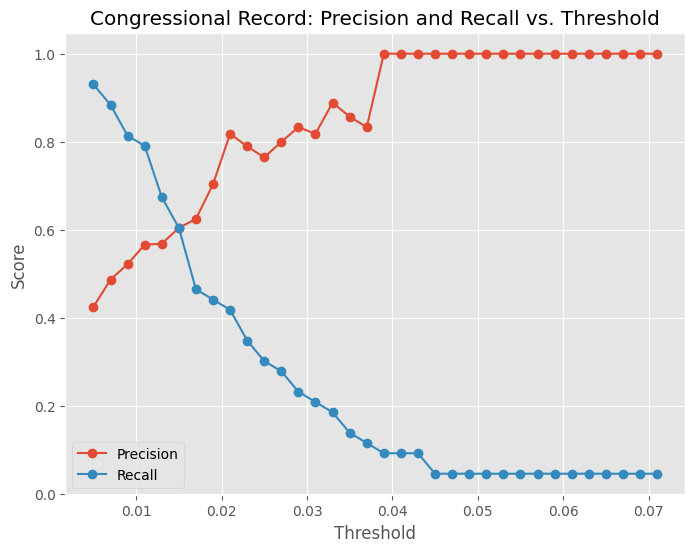

In [16]:
classified_congressional_record_sample = pd.read_csv(
    DATA_PATH + 'classified_congressional_record_sample.csv')
labels = classified_congressional_record_sample['climate_change_content']

start_threshold = 0.005
end_threshold = 0.07
step = 0.002

thresholds = np.arange(start_threshold, end_threshold + step, step)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    predicted_climate_change_content = topic_stems_filter(
        classified_congressional_record_sample, climate_stems, threshold)
    classified_congressional_record_sample['predicted_climate_change_content'] = classified_congressional_record_sample.index.isin(
        predicted_climate_change_content.index)
    predicted_labels = classified_congressional_record_sample['predicted_climate_change_content']

    precision = precision_score(
        labels, predicted_labels, pos_label=True)
    recall = recall_score(labels, predicted_labels, pos_label=True)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot precision and recall scores against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, marker='o', label='Precision')
plt.plot(thresholds, recall_scores, marker='o', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Congressional Record: Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

**Hansard**


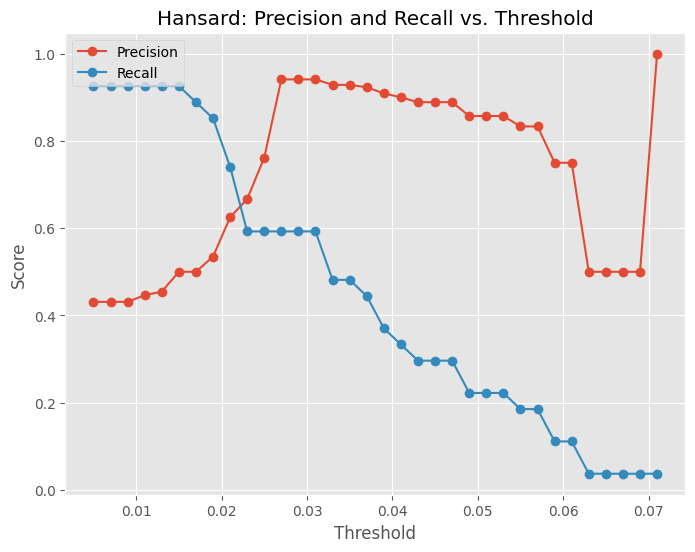

In [17]:
classified_hansard_sample = pd.read_csv(
    DATA_PATH + 'classified_hansard_sample.csv')
labels = classified_hansard_sample['climate_change_content']

start_threshold = 0.005
end_threshold = 0.07
step = 0.002

thresholds = np.arange(start_threshold, end_threshold + step, step)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    predicted_climate_change_content = topic_stems_filter(
        classified_hansard_sample, climate_stems, threshold)
    classified_hansard_sample['predicted_climate_change_content'] = classified_hansard_sample.index.isin(
        predicted_climate_change_content.index)
    predicted_labels = classified_hansard_sample['predicted_climate_change_content']

    precision = precision_score(
        labels, predicted_labels, pos_label=True)
    recall = recall_score(labels, predicted_labels, pos_label=True)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot precision and recall scores against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, marker='o', label='Precision')
plt.plot(thresholds, recall_scores, marker='o', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Hansard: Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Testing party balance


We also want to test how the filtering process affects the balance of parties in the filtered datasets. The threshold should not have a statistically significant effect on this balance. Otherwise, the following results are likely being driven by the filtering process rather than the content of the speeches.


**Congressional Record**


In [18]:
non_procedural_congressional_record = pd.read_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv')

Processing thresholds: 100%|██████████| 34/34 [03:58<00:00,  7.01s/it]


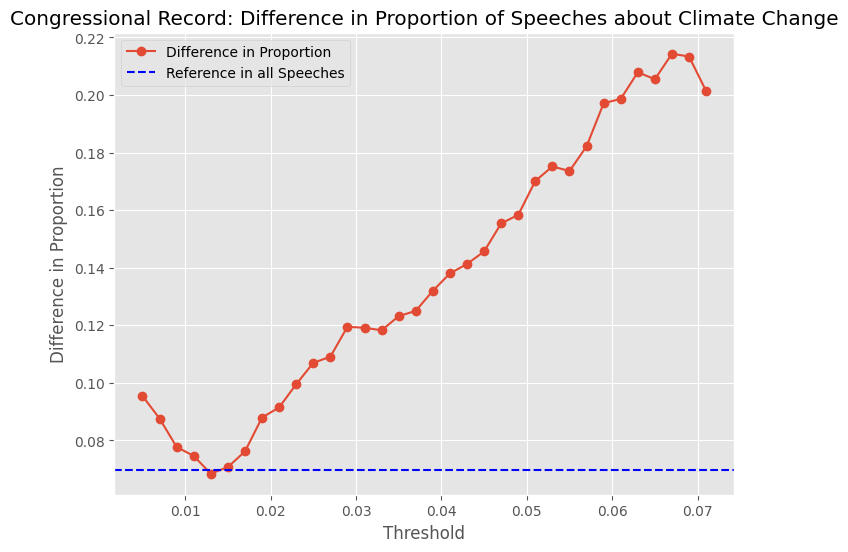

In [19]:
# Calculating the difference in the proportion of speeches made by Democrats and Republicans
# in the non-procedural Congressional Record
republican_speeches = non_procedural_congressional_record[
    non_procedural_congressional_record['party'] == 'R']
democratic_speeches = non_procedural_congressional_record[
    non_procedural_congressional_record['party'] == 'D']

prop_republican_speeches = len(
    republican_speeches) / len(non_procedural_congressional_record)
prop_democratic_speeches = len(
    democratic_speeches) / len(non_procedural_congressional_record)
diff_prop_speeches = prop_democratic_speeches - prop_republican_speeches

# Calculating the difference in the proportion of speeches about climate change
# made by Democrats and Republicans in the non-procedural Congressional Record
# at different thresholds
start_threshold = 0.005
end_threshold = 0.07
step = 0.002
thresholds = np.arange(start_threshold, end_threshold + step, step)

diff_prop_climate_speeches_list = []

for threshold in tqdm(thresholds, desc="Processing thresholds"):
    climate_congressional_record = topic_stems_filter(
        non_procedural_congressional_record, climate_stems, threshold)

    republican_climate_speeches = climate_congressional_record[
        climate_congressional_record['party'] == 'R']
    democratic_climate_speeches = climate_congressional_record[
        climate_congressional_record['party'] == 'D']

    prop_republican_climate_speeches = len(
        republican_climate_speeches) / len(climate_congressional_record)
    prop_democratic_climate_speeches = len(
        democratic_climate_speeches) / len(climate_congressional_record)

    diff_prop_climate_speeches = prop_democratic_climate_speeches - \
        prop_republican_climate_speeches
    diff_prop_climate_speeches_list.append(diff_prop_climate_speeches)

# Plotting the difference in proportion of speeches about climate change against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, diff_prop_climate_speeches_list,
         marker='o', label='Difference in Proportion')
plt.axhline(y=diff_prop_speeches, color='b', linestyle='--',
            label='Reference in all Speeches')
plt.xlabel('Threshold')
plt.ylabel('Difference in Proportion')
plt.title(
    'Congressional Record: Difference in Proportion of Speeches about Climate Change')
plt.grid(True)
plt.legend()
plt.show()

**Hansard**


In [20]:
non_procedural_hansard = pd.read_csv(DATA_PATH + 'non_procedural_hansard.csv')

Processing thresholds: 100%|██████████| 34/34 [01:19<00:00,  2.34s/it]


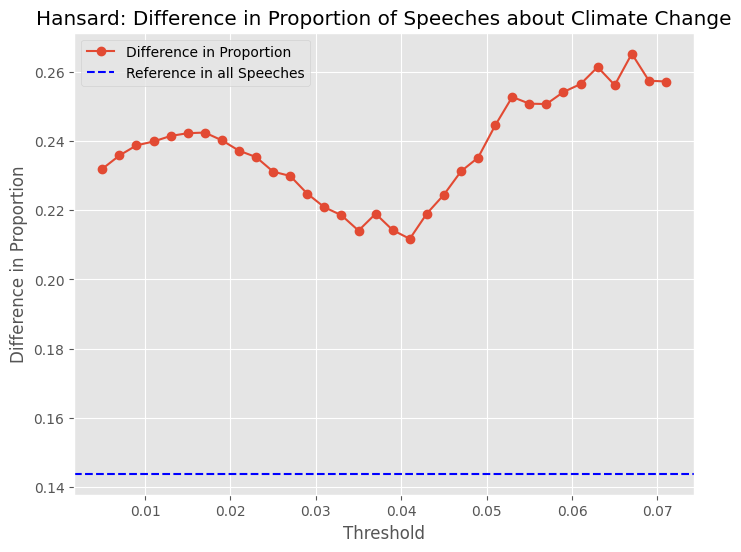

In [21]:
# Calculating the difference in the proportion of speeches made by Conservative and Labour
# MPs in the non-procedural Hansard
conservative_speeches = non_procedural_hansard[
    non_procedural_hansard['speech_party'] == 'Conservative']
labour_speeches = non_procedural_hansard[
    non_procedural_hansard['speech_party'] == 'Labour']

prop_conservative_speeches = len(
    conservative_speeches) / len(non_procedural_hansard)
prop_labour_speeches = len(labour_speeches) / len(non_procedural_hansard)
diff_prop_speeches = prop_labour_speeches - prop_conservative_speeches

# Calculating the difference in the proportion of speeches about climate change
# made by Conservative and Labour MPs in the non-procedural Hansard at different thresholds
start_threshold = 0.005
end_threshold = 0.07
step = 0.002

thresholds = np.arange(start_threshold, end_threshold + step, step)
diff_prop_climate_speeches_list = []

for threshold in tqdm(thresholds, desc="Processing thresholds"):
    climate_hansard = topic_stems_filter(
        non_procedural_hansard, climate_stems, threshold)

    conservative_climate_speeches = climate_hansard[
        climate_hansard['speech_party'] == 'Conservative']
    labour_climate_speeches = climate_hansard[
        climate_hansard['speech_party'] == 'Labour']

    prop_conservative_climate_speeches = len(
        conservative_climate_speeches) / len(climate_hansard)
    prop_labour_climate_speeches = len(
        labour_climate_speeches) / len(climate_hansard)

    diff_prop_climate_speeches = prop_labour_climate_speeches - \
        prop_conservative_climate_speeches
    diff_prop_climate_speeches_list.append(diff_prop_climate_speeches)

# Plot the difference in proportion of speeches about climate change against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, diff_prop_climate_speeches_list,
         marker='o', label='Difference in Proportion')
plt.axhline(y=diff_prop_speeches, color='b', linestyle='--',
            label='Reference in all Speeches')
plt.xlabel('Threshold')
plt.ylabel('Difference in Proportion')
plt.title('Hansard: Difference in Proportion of Speeches about Climate Change')
plt.grid(True)
plt.legend()
plt.show()